In [205]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from scipy.stats import ttest_ind, f_oneway, normaltest
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uk-smoking-data/smoking.csv


In [206]:
df = pd.read_csv('/kaggle/input/uk-smoking-data/smoking.csv')

In [207]:
df.head()

,gender,age,marital_status,highest_qualification,nationality,ethnicity,gross_income,region,smoke,amt_weekends,amt_weekdays,type
0,Male,38,Divorced,No Qualification,British,White,"2,600 to 5,200",The North,No,NaN,NaN,NaN
1,Female,42,Single,No Qualification,British,White,"Under 2,600",The North,Yes,12.0,12.0,Packets
2,Male,40,Married,Degree,English,White,"28,600 to 36,400",The North,No,NaN,NaN,NaN
3,Female,40,Married,Degree,English,White,"10,400 to 15,600",The North,No,NaN,NaN,NaN
4,Female,39,Married,GCSE/O Level,British,White,"2,600 to 5,200",The North,No,NaN,NaN,NaN


# Some Relations I would like to discover:

1) Relationship between each factor and smoking. \
2) Which age group tends to smoke most? \
3) Do regions affect the smoking tendencies? \
4) How does ethnicity affect smoking habits? \
5) Do ethnicites relate to smoking habits differently in different regions? \
6) What about qualification? Can a higher qualification change smoking habits? \
7) Does Marital Status affect the rates of smoking in genders?

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 1691 non-null   object 
 1   age                    1691 non-null   int64  
 2   marital_status         1691 non-null   object 
 3   highest_qualification  1691 non-null   object 
 4   nationality            1691 non-null   object 
 5   ethnicity              1691 non-null   object 
 6   gross_income           1691 non-null   object 
 7   region                 1691 non-null   object 
 8   smoke                  1691 non-null   object 
 9   amt_weekends           421 non-null    float64
 10  amt_weekdays           421 non-null    float64
 11  type                   421 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 158.7+ KB


In [209]:
df.drop(columns=['amt_weekends', 'amt_weekdays', 'type'], inplace=True)

In [210]:
df.isnull().sum()

gender                   0
age                      0
marital_status           0
highest_qualification    0
nationality              0
ethnicity                0
gross_income             0
region                   0
smoke                    0
dtype: int64

In [211]:
unique_elements = {}

for column in df.columns:
    if column != 'age':
        unique_elements[column] = df[column].unique()

unique_elements

{'gender': array(['Male', 'Female'], dtype=object),
 'marital_status': array(['Divorced', 'Single', 'Married', 'Widowed', 'Separated'],
       dtype=object),
 'highest_qualification': array(['No Qualification', 'Degree', 'GCSE/O Level', 'GCSE/CSE',
        'Other/Sub Degree', 'Higher/Sub Degree', 'ONC/BTEC', 'A Levels'],
       dtype=object),
 'nationality': array(['British', 'English', 'Scottish', 'Other', 'Welsh', 'Irish',
        'Refused', 'Unknown'], dtype=object),
 'ethnicity': array(['White', 'Mixed', 'Black', 'Refused', 'Asian', 'Chinese',
        'Unknown'], dtype=object),
 'gross_income': array(['2,600 to 5,200', 'Under 2,600', '28,600 to 36,400',
        '10,400 to 15,600', '15,600 to 20,800', 'Above 36,400',
        '5,200 to 10,400', 'Refused', '20,800 to 28,600', 'Unknown'],
       dtype=object),
 'region': array(['The North', 'Midlands & East Anglia', 'London', 'South East',
        'South West', 'Wales', 'Scotland'], dtype=object),
 'smoke': array(['No', 'Yes'], dtype=o

In [212]:
def parse_null(table):
    table = table.copy()
    for column in table.columns:
        table[column] = table[column].apply(func=lambda x: np.nan if x in ['Refused', 'Unknown'] else x)
    return table

In [213]:
df = parse_null(df).copy()

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 1691 non-null   object
 1   age                    1691 non-null   int64 
 2   marital_status         1691 non-null   object
 3   highest_qualification  1691 non-null   object
 4   nationality            1673 non-null   object
 5   ethnicity              1676 non-null   object
 6   gross_income           1565 non-null   object
 7   region                 1691 non-null   object
 8   smoke                  1691 non-null   object
dtypes: int64(1), object(8)
memory usage: 119.0+ KB


# Relationship between each factor and smoking

In [215]:
# Transforming the smoke column into 0 and 1.

df['smoke'] = df['smoke'].apply(func=lambda x: 1 if x == 'Yes' else 0)

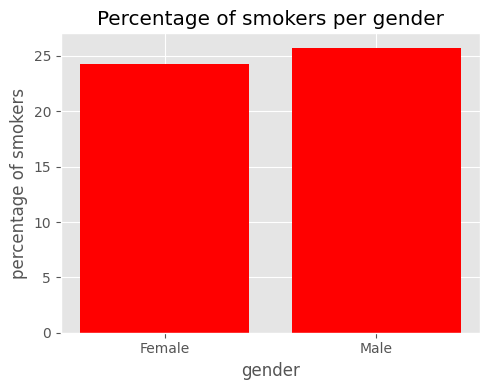

In [216]:
# Relationship between gender and smoking.

gender_smoking_data = df.groupby('gender').agg({
    'smoke': 'mean'
}).reset_index()

plt.figure(figsize=(5, 4))
plt.bar(gender_smoking_data['gender'], 100*gender_smoking_data['smoke'], color='red')
plt.title('Percentage of smokers per gender')
plt.xlabel('gender')
plt.ylabel('percentage of smokers')
plt.tight_layout()

plt.show()

#### If we let $\bar{X}$ and $\bar{Y}$ be the sample proportions of smokers for males and females, respectively, and if we assume $X \rightarrow \mathcal{S_1}(\mu_{male}, \sigma_{male}^2)$ and $Y \rightarrow \mathcal{S_2}(\mu_{female}, \sigma_{female}^2)$ for some probability distributions $\mathcal{S_1}$ and $\mathcal{S_2}$, then by the Central Limit Theorem the proportions are approximately normal with  $\bar{X} \rightarrow \mathcal{N}(\mu_{male}, \displaystyle\frac{\sigma_{male}^2}{n_{male}})$ and $\bar{Y} \rightarrow \mathcal{N}(\mu_{female}, \displaystyle\frac{\sigma_{female}^2}{n_{female}})$.

#### We now aim to test whether there are truly some differences between the means. Since we're dealing with two means, we will use a t - test at the 5% siginificance level (We can already see that most probably no pronounced differences exist, but we will test this nonetheless).

In [217]:
male_smoke = df['smoke'][df['gender'] == 'Male']
female_smoke = df['smoke'][df['gender'] == 'Female']

t_statistic, p_value = ttest_ind(male_smoke, female_smoke)

print(f"t statistic: {t_statistic}")
print(f"p value: {p_value}")

t statistic: 0.7099386350313722
p value: 0.47784019123747823


#### Since the p_value is much greater than our chosen 5% significance level, we can deduce that no statistical evidence suggests that we should reject the null.

#### We will now attempt to do the same for the other factors.

In [218]:
df.head()

,gender,age,marital_status,highest_qualification,nationality,ethnicity,gross_income,region,smoke
0,Male,38,Divorced,No Qualification,British,White,"2,600 to 5,200",The North,0
1,Female,42,Single,No Qualification,British,White,"Under 2,600",The North,1
2,Male,40,Married,Degree,English,White,"28,600 to 36,400",The North,0
3,Female,40,Married,Degree,English,White,"10,400 to 15,600",The North,0
4,Female,39,Married,GCSE/O Level,British,White,"2,600 to 5,200",The North,0


In [219]:
unique_elements_len = {list(unique_elements.keys())[i]: len(list(unique_elements.values())[i]) for i in range(len(unique_elements))}

In [220]:
f_statistic, p_value = f_oneway(*[df['smoke'][df['region'] == status] for status in unique_elements['region']])

print(f_statistic)
print(p_value)

2.1189310387572067
0.04839328920425179


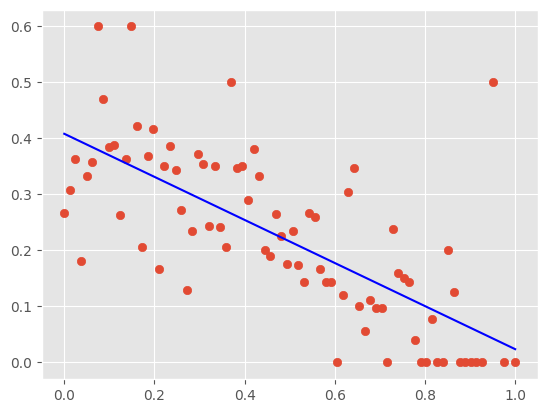

In [221]:
temp = \
df.groupby('age').agg({
    'smoke': 'mean'
}).reset_index()

standarized_temp_age = (temp['age'] - np.min(temp['age']))/(np.max(temp['age']) - np.min(temp['age']))

b1, b0 = np.polyfit(standarized_temp_age, temp['smoke'], 1)
x_ = np.linspace(0, 1, 1000)
y_ = b0 + b1*x_

plt.scatter(standarized_temp_age, temp['smoke'])
plt.plot(x_, y_, color='blue')

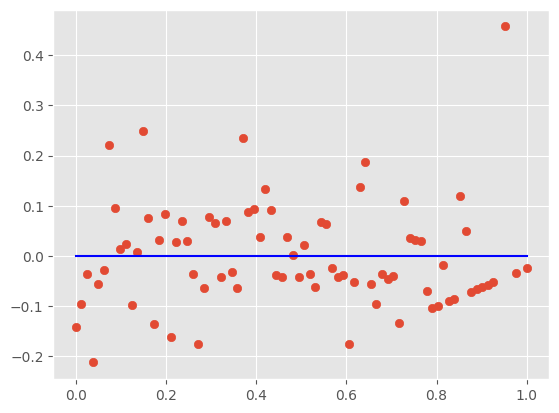

In [222]:
plt.scatter(standarized_temp_age, temp['smoke'] - (b0 + b1*standarized_temp_age))
plt.plot(np.linspace(0, 1, 200), [0]*200, color='blue')

In [223]:
from sklearn.metrics import mean_squared_error

x_ = standarized_temp_age
y_ = b0 + b1*x_
y_t = temp['smoke']

np.sqrt(mean_squared_error(y_, y_t))

0.10558383182842818

In [224]:
df_marital_status = df.groupby('marital_status')['smoke'].mean().reset_index()

model = ols("smoke ~ C(marital_status)", data=df[['marital_status', 'smoke']]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

In [225]:
print(anova_table)
print("--------------------")
print(f"R^2: {model.rsquared}")

                       sum_sq      df          F        PR(>F)
C(marital_status)   14.019832     4.0  19.556674  9.542803e-16
Residual           302.165857  1686.0        NaN           NaN
--------------------
R^2: 0.04434050019347069


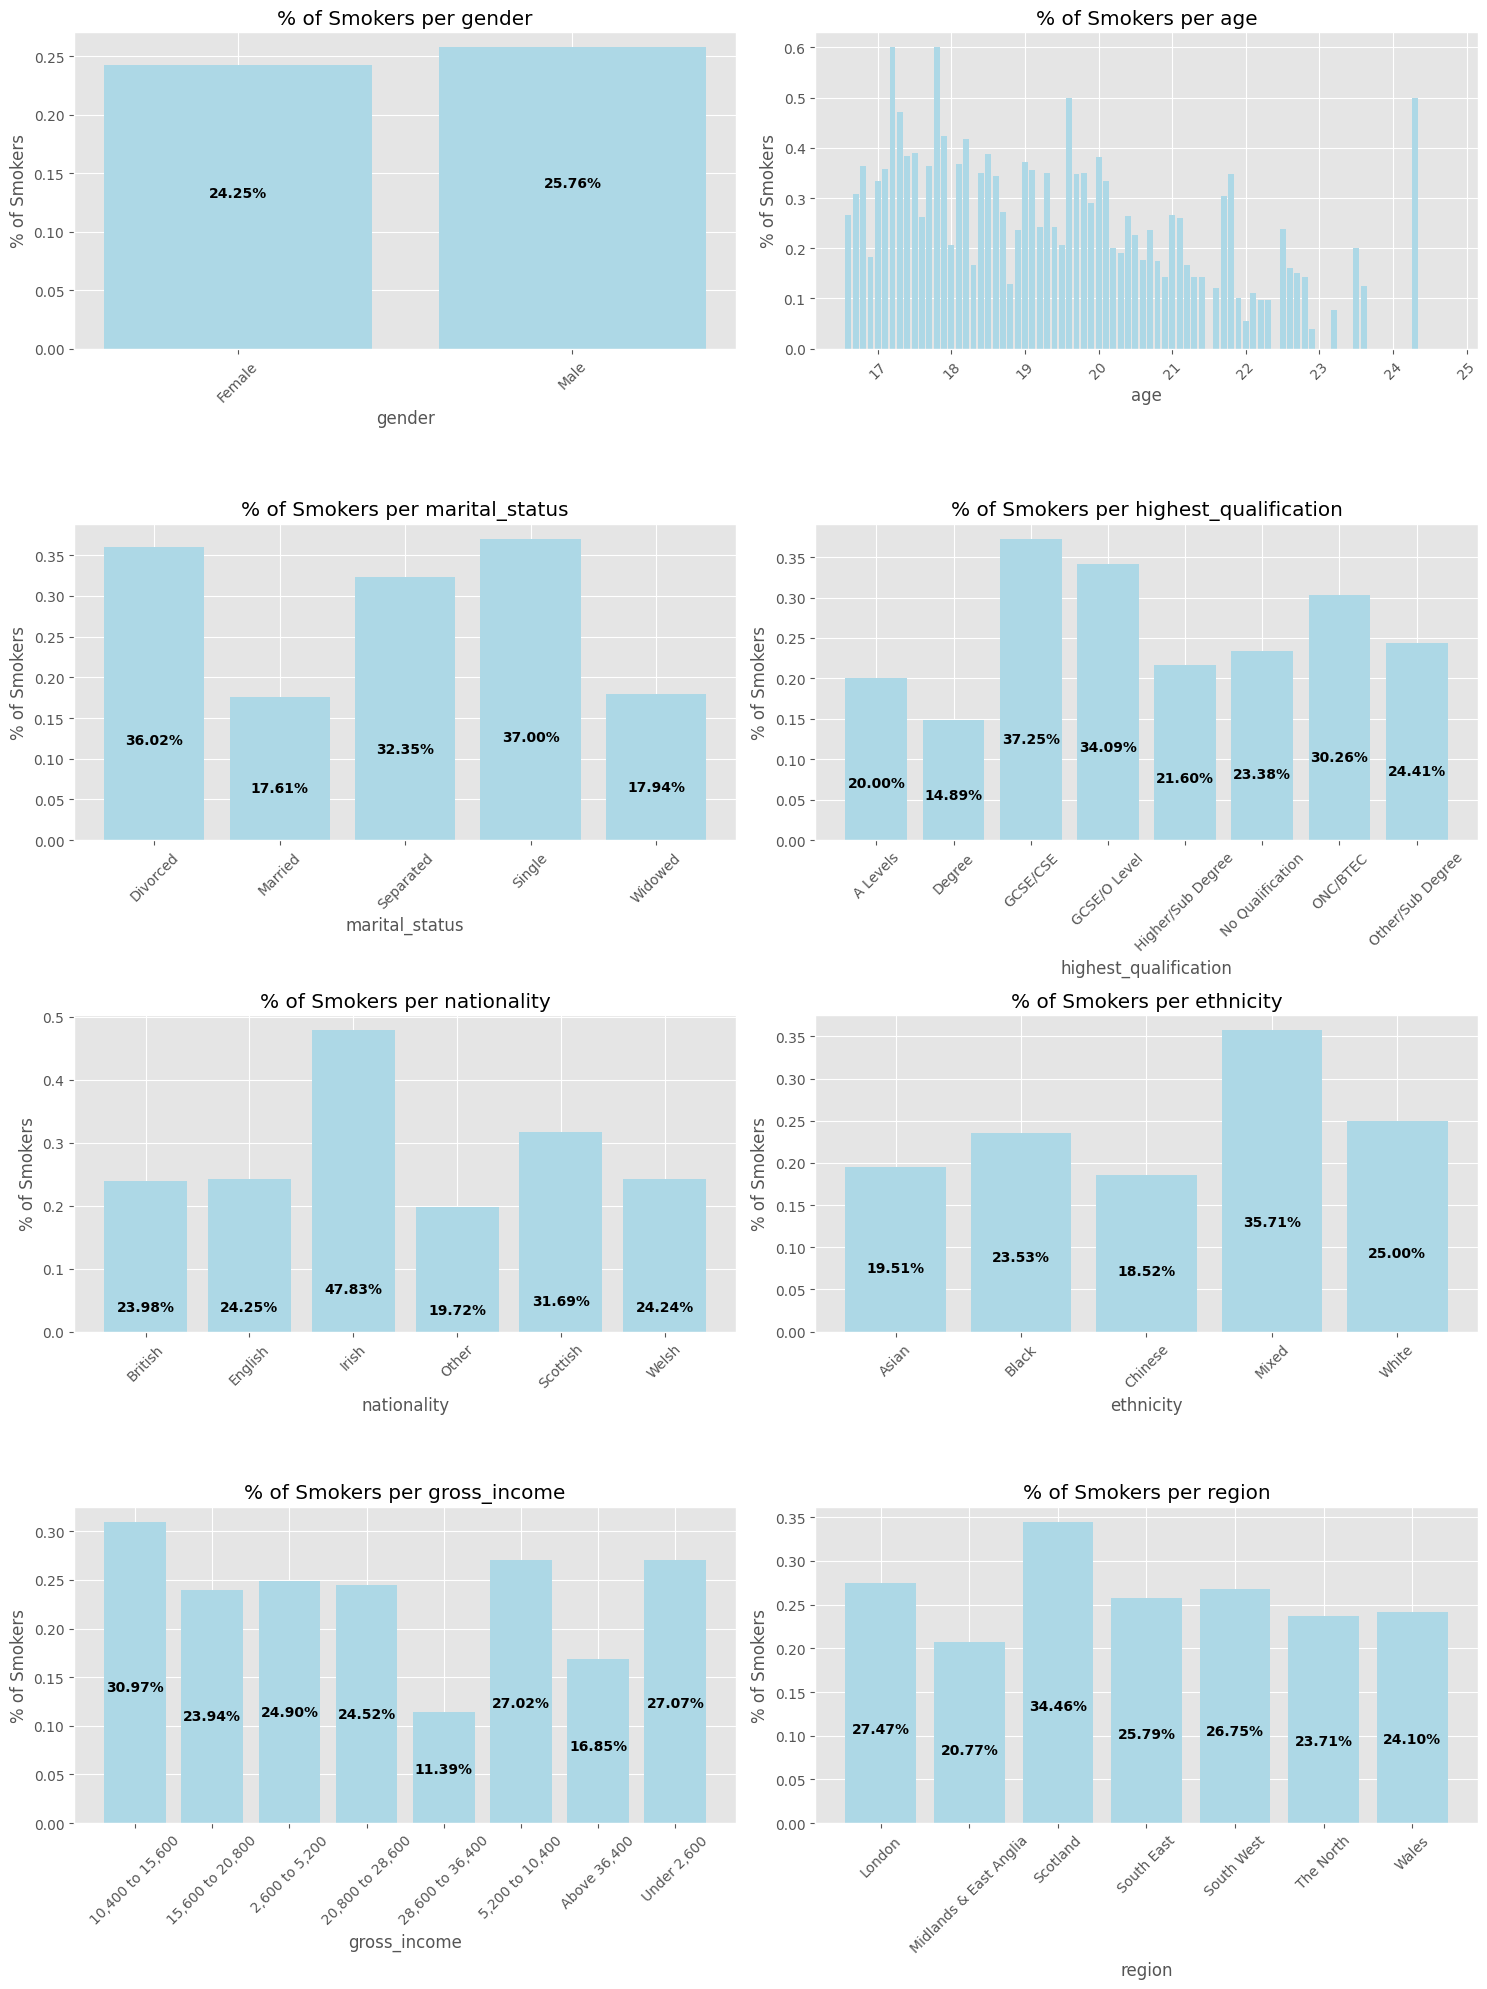

In [226]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20), constrained_layout=True)
columns = df.columns

for i in range(len(columns)):
    if columns[i] != 'smoke':
        table = df.groupby(columns[i]).agg({
            'smoke': 'mean'
        }).reset_index()

        bars = axs[i // 2][i % 2].bar(table[columns[i]], table['smoke'], color='lightblue')
        axs[i // 2][i % 2].set_xticklabels(table[columns[i]], rotation=45)
        axs[i // 2][i % 2].set_title(f'% of Smokers per {columns[i]}')
        axs[i // 2][i % 2].set_ylabel('% of Smokers')
        axs[i // 2][i % 2].set_xlabel(f'{columns[i]}')
        
        if columns[i] != 'age':
            for bar in bars:
                height = bar.get_height()
                axs[i // 2][i % 2].annotate(f'{100*height:.2f}%', 
                                           xy=(bar.get_x() + bar.get_width() / 2, height),
                                           xytext=(0, -height*400),
                                           textcoords="offset points",
                                           ha='center', va='bottom',
                                           weight='bold')

plt.tight_layout()
plt.show()

#### If we let $\bar{X}$ be the sample proportion of smokers for any of the given features, and if we assume $X \rightarrow \mathcal{S}(\mu, \sigma^2)$ for some probability distribution $\mathcal{S}$, then by the Central Limit Theorem the sample proportion is approximately normal with $\bar{X} \rightarrow \mathcal{N}(\mu, \displaystyle\frac{\sigma^2}{n})$, where $n$ is the sample size.

In [229]:
df.describe()

,age,smoke
count,1691.000000,1691.000000
mean,49.836192,0.248965
std,18.736851,0.432541
min,16.000000,0.000000
25%,34.000000,0.000000
50%,48.000000,0.000000
75%,65.500000,0.000000
max,97.000000,1.000000


<Axes: ylabel='Frequency'>

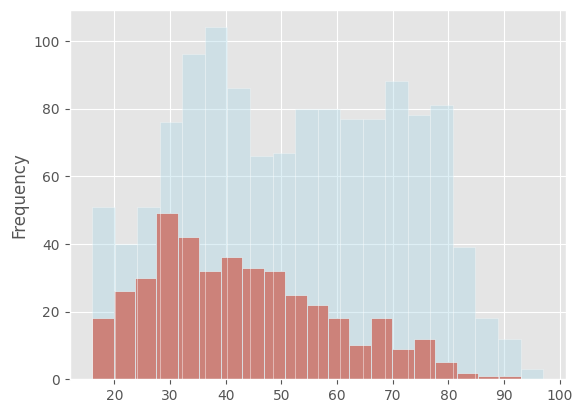

In [230]:
df['age'][df['smoke'] == 1].plot(kind='hist', bins=20, edgecolor="white")
df['age'][df['smoke'] == 0].plot(kind='hist', bins=20, edgecolor="white", alpha=0.4, color='lightblue')

<Axes: ylabel='Density'>

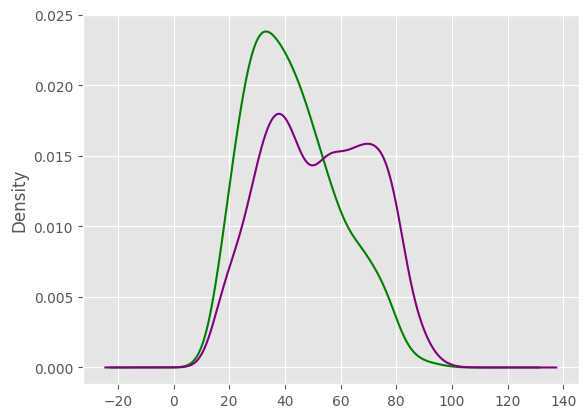

In [231]:
df['age'][df['smoke'] == 1].plot(kind='kde', color='green')
df['age'][df['smoke'] == 0].plot(kind='kde', color='purple')

In [232]:
df

,gender,age,marital_status,highest_qualification,nationality,ethnicity,gross_income,region,smoke
0,Male,38,Divorced,No Qualification,British,White,"2,600 to 5,200",The North,0
1,Female,42,Single,No Qualification,British,White,"Under 2,600",The North,1
2,Male,40,Married,Degree,English,White,"28,600 to 36,400",The North,0
3,Female,40,Married,Degree,English,White,"10,400 to 15,600",The North,0
4,Female,39,Married,GCSE/O Level,British,White,"2,600 to 5,200",The North,0
...,...,...,...,...,...,...,...,...,...
1686,Male,22,Single,No Qualification,Scottish,White,"2,600 to 5,200",Scotland,0
1687,Female,49,Divorced,Other/Sub Degree,English,White,"2,600 to 5,200",Scotland,1
1688,Male,45,Married,Other/Sub Degree,Scottish,White,"5,200 to 10,400",Scotland,0
1689,Female,51,Married,No Qualification,English,White,"2,600 to 5,200",Scotland,1


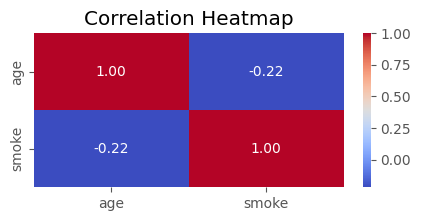

In [235]:
plt.figure(figsize=(5, 2))
sns.heatmap(df[['age', 'smoke']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [240]:
df.describe(include='all').replace({np.nan: '---'})

,gender,age,marital_status,highest_qualification,nationality,ethnicity,gross_income,region,smoke
count,1691,1691.0,1691,1691,1673,1676,1565,1691,1691.0
unique,2,---,5,8,6,5,8,7,---
top,Female,---,Married,No Qualification,English,White,"5,200 to 10,400",Midlands & East Anglia,---
freq,965,---,812,586,833,1560,396,443,---
mean,---,49.836192,---,---,---,---,---,---,0.248965
std,---,18.736851,---,---,---,---,---,---,0.432541
min,---,16.0,---,---,---,---,---,---,0.0
25%,---,34.0,---,---,---,---,---,---,0.0
50%,---,48.0,---,---,---,---,---,---,0.0
75%,---,65.5,---,---,---,---,---,---,0.0
